Wildfires are a significant threat to ecosystems, human health, and infrastructure, making early detection crucial. Traditional object detection models require extensive labeled datasets, which are resource-intensive to create. This research explores the application of a zero-shot object detection model, CLIP (Contrastive Language-Image Pretraining), for detecting wildfire smoke without needing specialized training data.

Developed by OpenAI, CLIP leverages large-scale pretraining on diverse image and text datasets, allowing it to generalize to new, unseen categories. This study employs CLIP's zero-shot capabilities to identify wildfire smoke in a given dataset. We evaluate the model's performance using standard object detection metrics, such as precision, recall, and mean average precision (mAP), and also visual inspection of the results.

In [140]:
import zipfile
import os

In [141]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [142]:
zip_file_path = '/content/gdrive/MyDrive/ML/projects/object-detection/wildfire-smoke/Wildfire Smoke.v1-raw.yolov8.zip'
extract_dir = 'Wildfire Smoke.v1-raw.yolov8'
os.makedirs(extract_dir, exist_ok = True)

In [143]:
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extraction complete.")

Extraction complete.


In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from tqdm.auto import tqdm

from PIL import Image, ImageDraw

import torch
from torchvision import transforms
from transformers import CLIPProcessor, CLIPModel

from skimage.measure import label, regionprops

import json
import glob
import cv2

from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix, f1_score

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from itertools import count

import random

#Demo

In [6]:
im = Image.open(r"/content/Wildfire Smoke.v1-raw.yolov8/test/images/ck0kcoc8ik6ni0848clxs0vif_jpeg.rf.8b4629777ffe1d349cc970ee8af59eac.jpg")

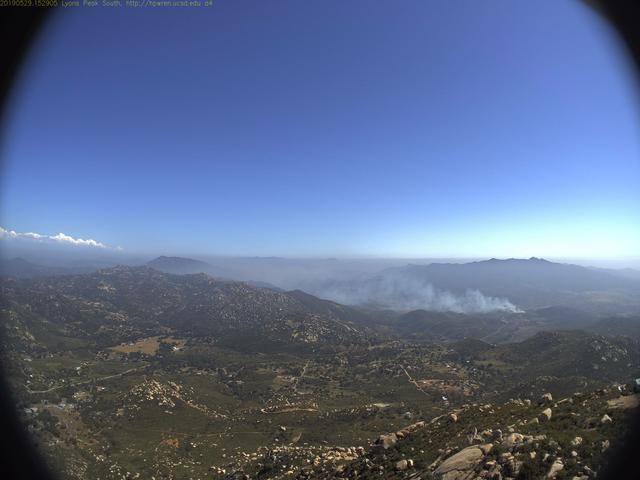

In [7]:
im

### Cut image into patches

Transform the image into a tensor.

In [8]:
trans_t = transforms.ToTensor()
img = trans_t(im)

In [9]:
img.shape

torch.Size([3, 480, 640])

Add batch dimension and reshape.

In [10]:
patched_image = img.permute(1, 2, 0).unsqueeze(0)

In [11]:
patched_image.shape

torch.Size([1, 480, 640, 3])

Now we will split the image into patches of a given size (PATCH_SIZE), first vertically, then horizontally.

In [12]:
PATCH_SIZE = 32

In [13]:
patched_image = patched_image.unfold(1, PATCH_SIZE, PATCH_SIZE)

In [14]:
patched_image.shape

torch.Size([1, 15, 640, 3, 32])

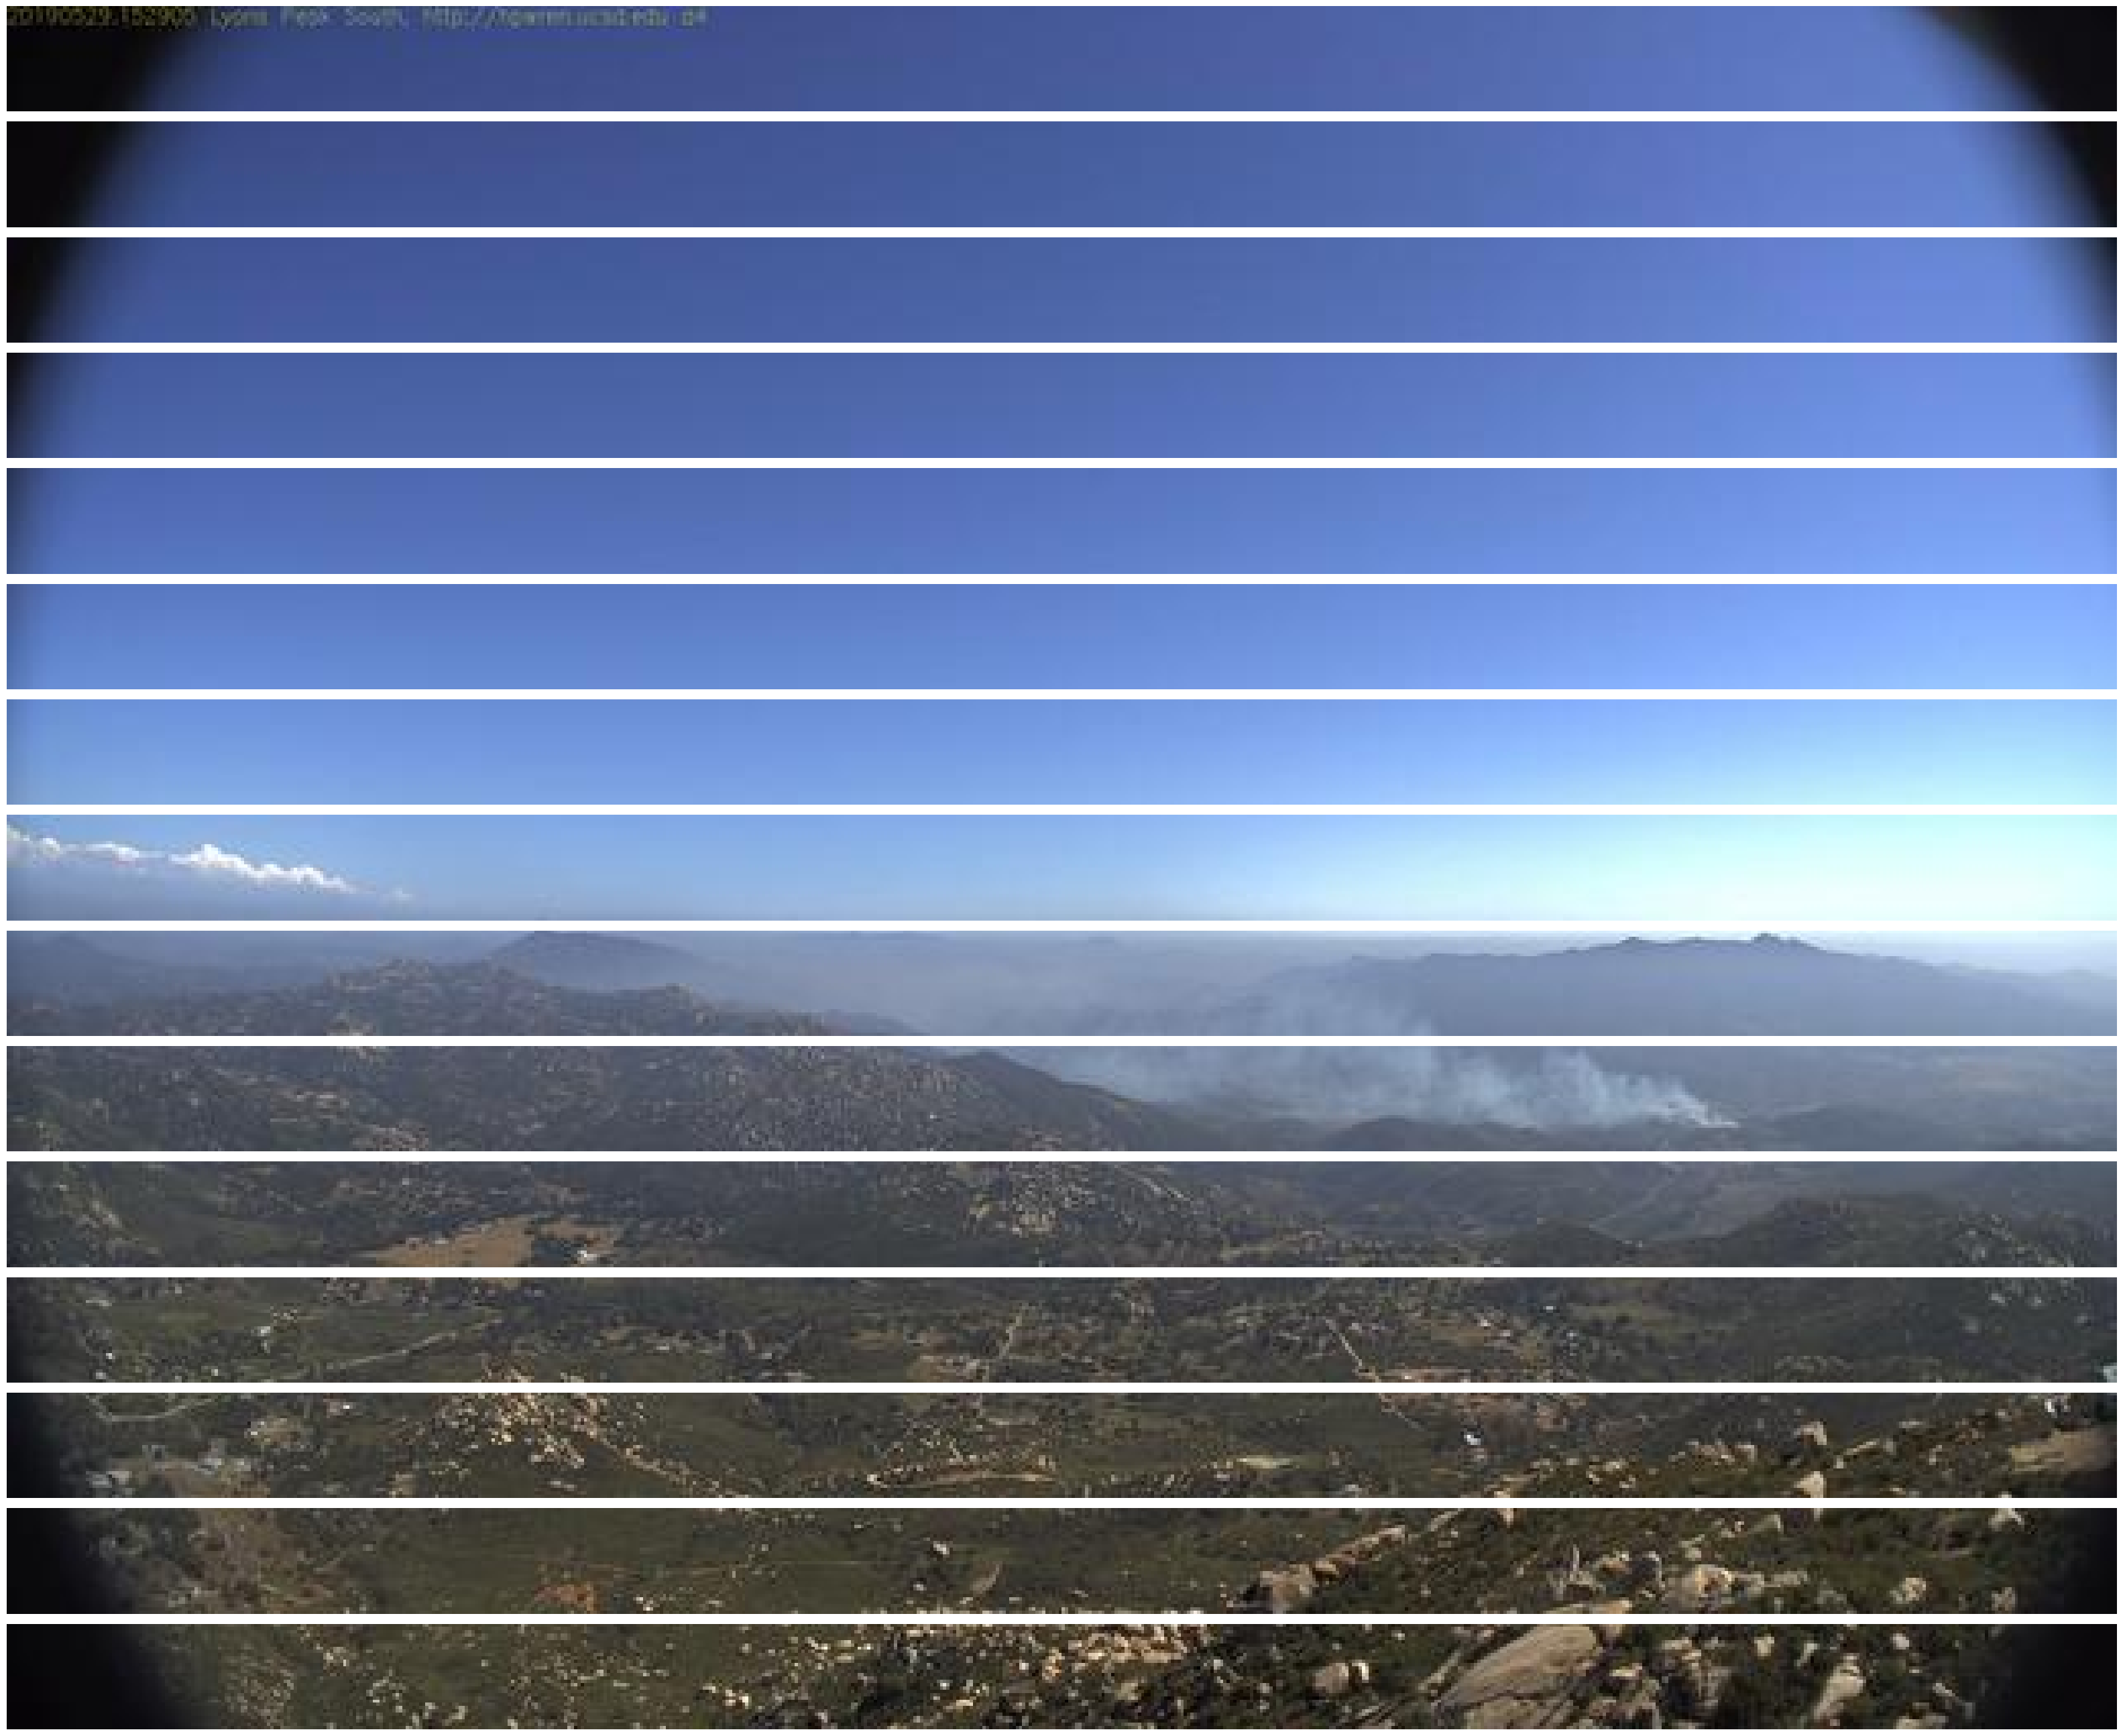

In [15]:
X = patched_image.shape[1]

fig, ax = plt.subplots(X, 1, figsize = (40, 26))

for x in range(X):
  ax[x].imshow(patched_image[0, x].permute(2, 0, 1))
  ax[x].axis('off')

fig.tight_layout()
plt.show()

In [16]:
patched_image = patched_image.unfold(2, PATCH_SIZE, PATCH_SIZE)

In [17]:
patched_image.shape

torch.Size([1, 15, 20, 3, 32, 32])

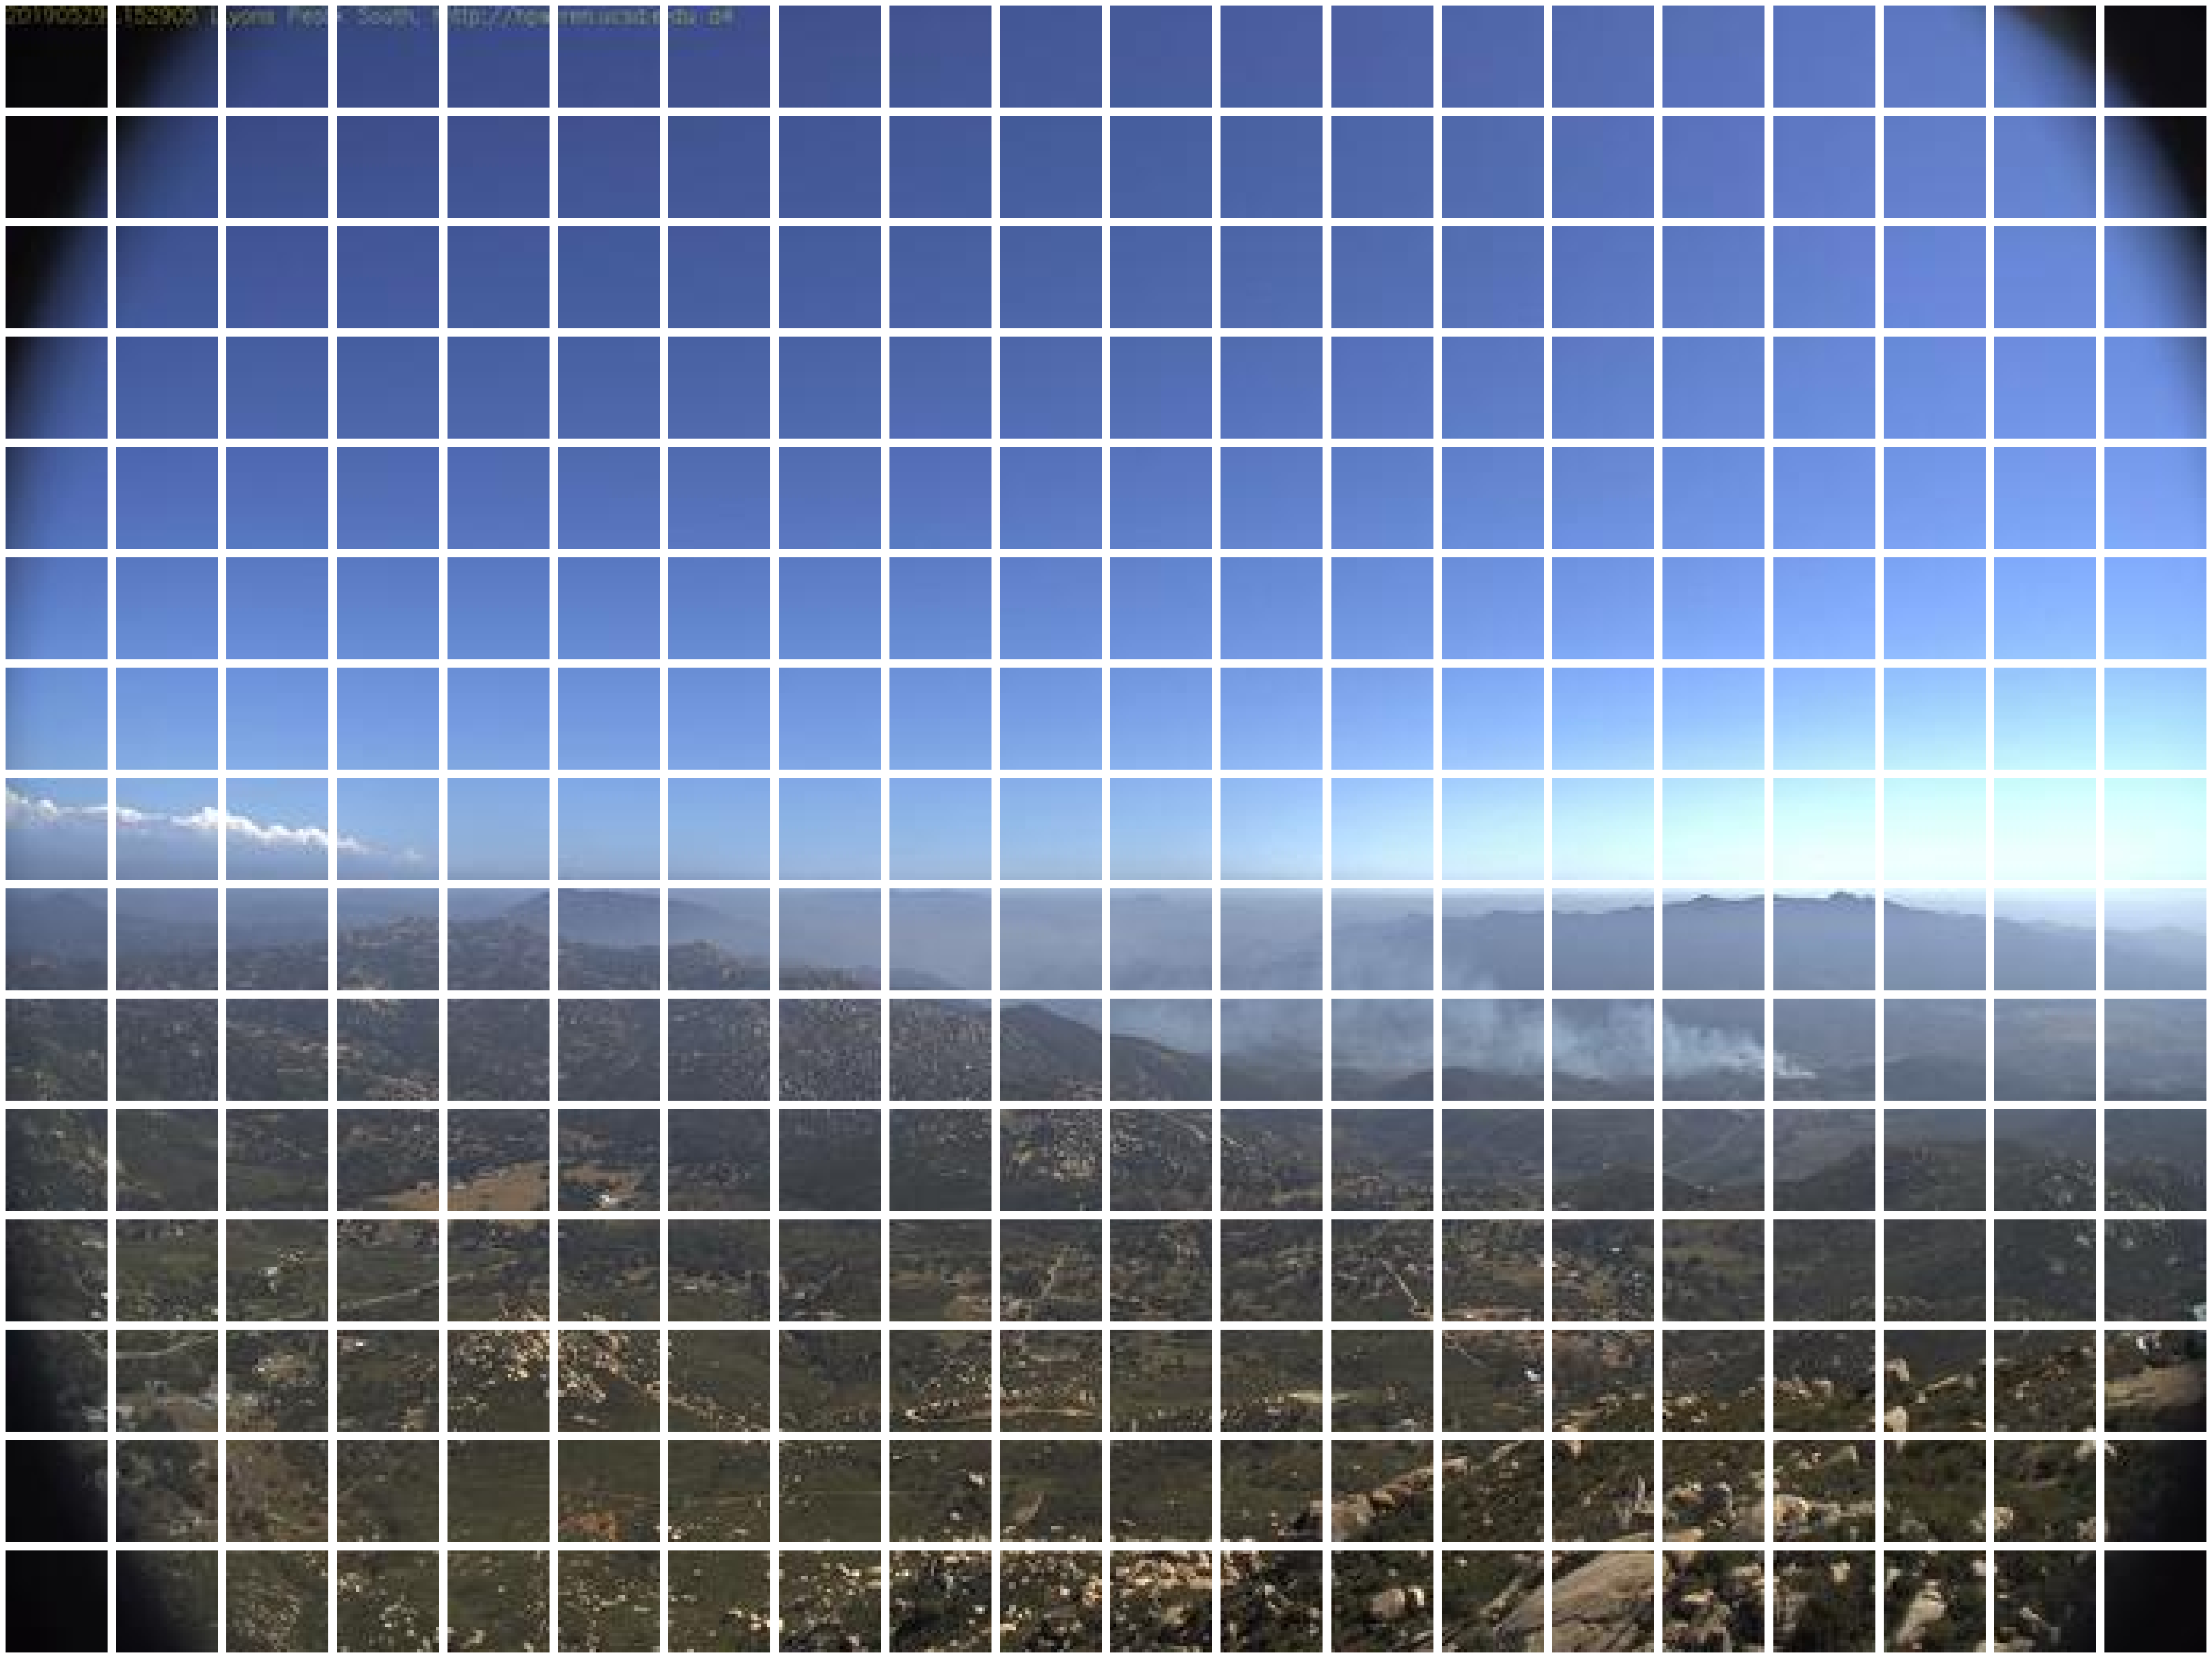

In [18]:
X = patched_image.shape[1]
Y = patched_image.shape[2]

fig, ax = plt.subplots(X, Y, figsize = (Y*2, X*2))

for x in range(X):
  for y in range(Y):
    ax[x, y].imshow(patched_image[0, x, y].permute(1, 2, 0))
    ax[x, y].axis('off')

fig.tight_layout()
#plt.savefig('CLIP_patched_sample_image.png', dpi = 600)
plt.show()

### Get CLIP model

In [19]:
model_id = "openai/clip-vit-base-patch32"

processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(device)

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

### Calculate scores

In [21]:
def get_big_patch(patched_image, Y, X, window):

    # Get the current batch of patches that will make big_patch
    patch_batch = patched_image[0, Y:Y + window, X:X + window]

    # Initialize an empty big_patch array
    big_patch = torch.zeros(window * patch_batch.shape[3], window * patch_batch.shape[4], 3)

    # Fill in the big_patch
    for y in range(window):
        for x in range(window):
            big_patch[
                y * patch_batch.shape[3]:(y + 1) * patch_batch.shape[3],
                x * patch_batch.shape[4]:(x + 1) * patch_batch.shape[4], :
            ] = patch_batch[y, x].permute(1, 2, 0)

    return big_patch

In [22]:
PROMPT = 'wildfire smoke'
WINDOW = 6
STRIDE = 1

In [23]:
scores = torch.zeros(patched_image.shape[1], patched_image.shape[2])
runs = torch.ones(patched_image.shape[1], patched_image.shape[2])

for Y in range(0, patched_image.shape[1]-WINDOW+1, STRIDE):
  for X in range(0, patched_image.shape[2]-WINDOW+1, STRIDE):

    big_patch = get_big_patch(patched_image, Y, X, WINDOW)

    inputs = processor(
        images = big_patch,
        return_tensors = "pt",
        text = PROMPT,  # class label
        padding = True,
        do_rescale = False
        ).to(device)

    # calculate and retrieve similarity score
    score = model(**inputs).logits_per_image.item()
    # sum up similarity scores from current and previous big patches that were calculated for patches within the current window
    scores[Y:Y+WINDOW, X:X+WINDOW] += score
    # calculate the number of runs on each patch within the current window
    runs[Y:Y+WINDOW, X:X+WINDOW] += 1

In [24]:
scores /= runs

In [25]:
# repeatedly adjust the 'scores' array by subtracting its mean and clipping negative values to zero, N_CLIP times
# this process aims to normalize and remove negative deviations
N_CLIP = 4

for i in range(N_CLIP):
  scores = np.clip(scores-scores.mean(), 0, np.inf)

# normalize scores
scores = (scores - scores.min()) / (scores.max() - scores.min())

In [26]:
scores.shape, patched_image.shape

(torch.Size([15, 20]), torch.Size([1, 15, 20, 3, 32, 32]))

### Visualize found scores

In [27]:
adjusted_patched_image = patched_image.squeeze(0).permute(3, 4, 2, 0, 1)

In [28]:
adjusted_patched_image = adjusted_patched_image * scores

# rotate patches to visualize
adjusted_patched_image = adjusted_patched_image.permute(3, 4, 2, 0, 1)

In [29]:
adjusted_patched_image.shape

torch.Size([15, 20, 3, 32, 32])

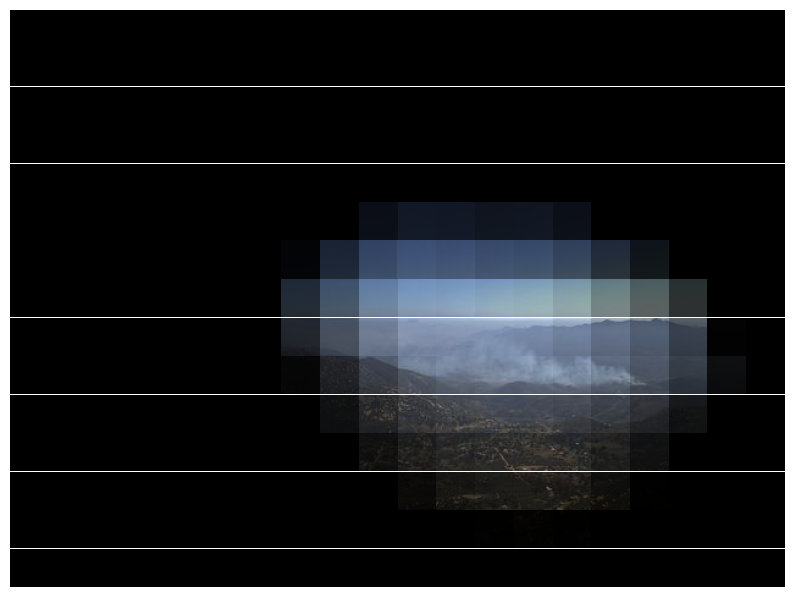

In [30]:
Y = adjusted_patched_image.shape[0]
X = adjusted_patched_image.shape[1]

fig, ax = plt.subplots(Y, X, figsize = (X*.5, Y*.5))

for y in range(Y):
    for x in range(X):
        ax[y, x].imshow(adjusted_patched_image[y, x].permute(1, 2, 0))
        ax[y, x].axis("off")
        ax[y, x].set_aspect('equal')

plt.subplots_adjust(wspace = 0, hspace = 0)
#plt.savefig('CLIP_found_scores_sample_image', dpi = 600)
plt.show()

### Determine coordinates and draw boxes

In [31]:
detection = scores > 0.5

In [32]:
detection.shape

torch.Size([15, 20])

In [33]:
# non-zero patch positions
np.nonzero(detection)

tensor([[ 6, 10],
        [ 7,  9],
        [ 7, 10],
        [ 7, 11],
        [ 7, 12],
        [ 7, 13],
        [ 7, 14],
        [ 7, 15],
        [ 8,  8],
        [ 8,  9],
        [ 8, 10],
        [ 8, 11],
        [ 8, 12],
        [ 8, 13],
        [ 8, 14],
        [ 8, 15],
        [ 8, 16],
        [ 9,  9],
        [ 9, 10],
        [ 9, 11],
        [ 9, 12],
        [ 9, 13],
        [ 9, 14],
        [ 9, 15],
        [ 9, 16],
        [10,  9],
        [10, 10],
        [10, 11],
        [10, 12],
        [10, 13],
        [10, 14],
        [10, 15],
        [10, 16],
        [11, 11],
        [11, 12],
        [11, 13],
        [11, 14]])

In [34]:
#use skimage.measure to determine areas of interest, where each area is a potential object we're searching for
labeled_image, num_features = label(detection, return_num = True)

In [35]:
regions = regionprops(labeled_image)

In [36]:
regions

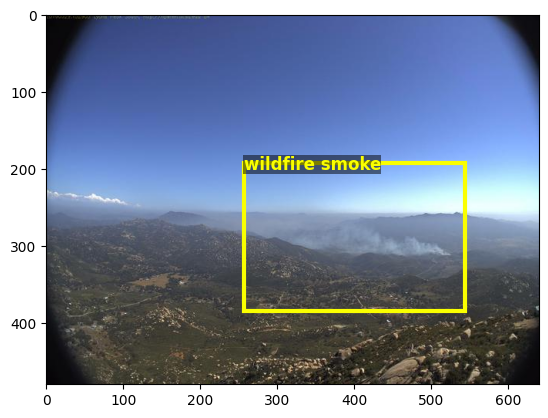

In [37]:
im_np = np.array(im)
fig, ax = plt.subplots(figsize = (im_np.shape[1] * 0.01, im_np.shape[0] * 0.01))
ax.imshow(im_np)

for region in regions:
    # Extract the bounding box coordinates
    y_min, x_min, y_max, x_max = region.bbox
    y_min *= PATCH_SIZE
    y_max *= PATCH_SIZE
    x_min *= PATCH_SIZE
    x_max *= PATCH_SIZE
    height = y_max - y_min
    width = x_max - x_min

    # Create a Rectangle patch
    rect = patches.Rectangle(
        (x_min, y_min), width, height,
        linewidth = 3, edgecolor = '#FAFF00', facecolor = 'none'
        )

    # Add the patch to the Axes
    ax.add_patch(rect)

    # Add label text near the bounding box
    ax.text(
        x_min, y_min - 10, PROMPT,
        verticalalignment = 'top', horizontalalignment = 'left',
        color = '#FAFF00', fontsize = 12, weight = 'bold',
        bbox = dict(facecolor = 'black', alpha = 0.5, pad = 0.2, edgecolor = 'none')
        )
#plt.savefig('CLIP_pred_sample_image.png', dpi = 600)
plt.show()

### Pipeline

Implement the above logic as functions.

In [153]:
def get_patched_image(img, patch_size = 32):

    patched_image = img.permute(1, 2, 0).unsqueeze(0)
    # cut the image into patches (vertically)
    patched_image = patched_image.unfold(1, patch_size, patch_size)
    # cut the image into patches (horizontally)
    patched_image = patched_image.unfold(2, patch_size, patch_size)
    return patched_image

In [154]:
def get_big_patch(patched_image, Y, X, window):

    # Get the current batch of patches that will make big_patch
    patch_batch = patched_image[0, Y:Y + window, X:X + window]

    # Initialize an empty big_patch array
    big_patch = torch.zeros(window * patch_batch.shape[3], window * patch_batch.shape[4], 3)

    # Fill in the big_patch
    for y in range(window):
        for x in range(window):
            big_patch[
                y * patch_batch.shape[3]:(y + 1) * patch_batch.shape[3],
                x * patch_batch.shape[4]:(x + 1) * patch_batch.shape[4], :
            ] = patch_batch[y, x].permute(1, 2, 0)

    return big_patch

In [155]:
def get_scores(patched_image, prompt, window = 6, stride = 1, n_clip = 4):

    scores = torch.zeros(patched_image.shape[1], patched_image.shape[2])
    runs = torch.ones(patched_image.shape[1], patched_image.shape[2])

    # iterate through patches
    for Y in range(0, patched_image.shape[1]-window+1, stride):
        for X in range(0, patched_image.shape[2]-window+1, stride):

            big_patch = get_big_patch(patched_image, Y, X, window)

            inputs = processor(
                images = big_patch,
                return_tensors = "pt",
                text = prompt,  # class label
                padding = True,
                do_rescale = False
                ).to(device)

            # calculate and retrieve similarity score
            score = model(**inputs).logits_per_image.item()
            # sum up similarity scores from current and previous big patches that were calculated for patches within the current window
            scores[Y:Y+window, X:X+window] += score
            # calculate the number of runs on each patch within the current window
            runs[Y:Y+window, X:X+window] += 1
    # calculate average scores
    scores /= runs
    # clip scores for a specified number of iterations
    for _ in range(n_clip):
        scores = np.clip(scores-scores.mean(), 0, np.inf)
    # normalize scores
    scores = (scores - scores.min()) / (scores.max() - scores.min())
    return scores

In [156]:
def get_boxes(scores, patch_size, threshold = 0.5):

    boxes = []
    detection = scores > threshold
    # determine areas of interest, where each area is a potential object we're searching for
    labeled_image, num_features = label(detection, return_num = True)
    regions = regionprops(labeled_image)
    for region in regions:
        # Extract the bounding box coordinates
        y_min, x_min, y_max, x_max = region.bbox
        y_min *= patch_size
        y_max *= patch_size
        x_min *= patch_size
        x_max *= patch_size
        height = y_max - y_min
        width = x_max - x_min
        boxes.append([x_min, y_min, width, height])
    return boxes

In [157]:
def detect(prompts, img, patch_size = 32, window = 6, stride = 1, n_clip = 4, threshold = 0.5):

    img_result = []

    patched_image = get_patched_image(img, patch_size)
    for i, prompt in enumerate(tqdm(prompts)):
        scores = get_scores(patched_image, prompt, window, stride, n_clip)
        boxes = get_boxes(scores, patch_size, threshold)
        if len(boxes) > 0:
          for box in boxes:
            img_result.append([i, box])

    return img_result

Provide a list of object classes we are searching for in the PROMPTS variable. This dataset contains only one class.

In [43]:
PROMPTS = ['wildfire smoke']
PATCH_SIZE = 16
WINDOW = 6
STRIDE = 1
N_CLIP = 10
THRESHOLD = 0.5

Apply the algorithm on a single image to test it.

In [44]:
im = Image.open(r"/content/Wildfire Smoke.v1-raw.yolov8/test/images/ck0qdgpy2ksso0721wbiaedz7_jpeg.rf.09a1a15cb63a9ec50be391f5afc5e199.jpg")

In [45]:
trans_t = transforms.ToTensor()
IMG = trans_t(im)

object_detection_results = detect(PROMPTS, IMG, PATCH_SIZE, WINDOW, STRIDE, N_CLIP, THRESHOLD)

  0%|          | 0/1 [00:00<?, ?it/s]

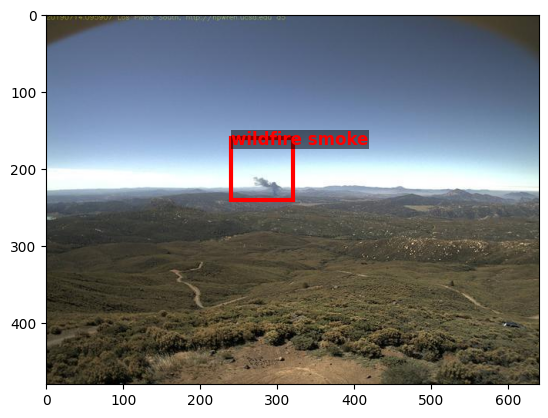

In [46]:
im_np = np.array(im)
fig, ax = plt.subplots(figsize = (im_np.shape[1] * 0.01, im_np.shape[0] * 0.01))
ax.imshow(im_np)

color_map = {
    "wildfire smoke": "#FF0000",  # Red
}

for res in object_detection_results:

    lbl = PROMPTS[res[0]]
    box = res[1]

    x_min, y_min, width, height = box[0], box[1], box[2], box[3]

    color = color_map.get(lbl)

    rect = patches.Rectangle(
        (x_min, y_min), width, height,
        linewidth = 3, edgecolor = color, facecolor = 'none'
        )

    # Add the patch to the Axes
    ax.add_patch(rect)

    # Add label text near the bounding box
    ax.text(
        x_min, y_min - 10, lbl,
        verticalalignment = 'top', horizontalalignment = 'left',
        color = color, fontsize = 12, weight = 'bold',
        bbox = dict(facecolor = 'black', alpha = 0.5, pad = 0.2, edgecolor = 'none')
        )

plt.show()

### Get results for the test set

In [47]:
IMAGE_DIR = "/content/Wildfire Smoke.v1-raw.yolov8/test/images"

trans_t = transforms.ToTensor()

In [48]:
PROMPTS = ['wildfire smoke']
PATCH_SIZE = 16
WINDOW = 6
STRIDE = 1
N_CLIP = 10
THRESHOLD = 0.5

In [49]:
def process_image(image_path, prompts, patch_size, window, stride, n_clip, threshold):
    im = Image.open(image_path)
    img_tensor = trans_t(im)
    object_detection_results = detect(prompts, img_tensor, patch_size, window, stride, n_clip, threshold)
    return object_detection_results

In [50]:
# results_list = []

# for image_name in os.listdir(IMAGE_DIR):
#     if image_name.endswith((".jpg", ".jpeg", ".png")):
#         image_path = os.path.join(IMAGE_DIR, image_name)
#         image_name_no_ext = os.path.splitext(image_name)[0]
#         detection_results = process_image(image_path, PROMPTS, PATCH_SIZE, WINDOW, STRIDE, N_CLIP, THRESHOLD)
#         results_list.append({
#             "image_name": image_name_no_ext,
#             "detection_results": detection_results
#         })

Save the results as a json object so that we can later access them without applying the model again.

In [51]:
# with open('/content/gdrive/MyDrive/ML/projects/object-detection/wildfire-smoke/test_clip_results.json', 'w') as f:
#     json.dump(results_list, f)

In [52]:
with open('/content/gdrive/MyDrive/ML/projects/object-detection/wildfire-smoke/test_clip_results.json', 'r') as f:
    results_list = json.load(f)

In [53]:
len(results_list)

74

In [54]:
results_list[:5]

[{'image_name': 'ck0uivtpc841h0a46ydgo7566_jpeg.rf.00134176dc2985f6029cddca1bb82930',
  'detection_results': [[0, [48, 144, 96, 48]], [0, [320, 144, 96, 112]]]},
 {'image_name': 'ck0ujw76nui2g0863hz7l7uqo_jpeg.rf.f6012893d20f44f903489d57c35ca95d',
  'detection_results': [[0, [304, 256, 224, 64]]]},
 {'image_name': 'ck0tzkkd8ulz70701xe5upkxe_jpeg.rf.902b7349e36e0120669f00c3cce74aeb',
  'detection_results': [[0, [384, 208, 144, 64]]]},
 {'image_name': 'ck0tszlepw02k0721zr71djfj_jpeg.rf.2c8ed6a3dc364fde6f615b9aaaadcde3',
  'detection_results': [[0, [512, 224, 96, 64]]]},
 {'image_name': 'ck0kosu846k350794gya7bot0_jpeg.rf.e980ecef63c864103fc6d8f4d8ed7ded',
  'detection_results': [[0, [480, 144, 128, 96]]]}]

### Calculate metrics and make visualizations

Convert the ground truth boxes and predicted boxes into the correct unified format, where each sample looks as follows:

{'image_name': 'ck0l9wcc5cyhb07010g94nwxz_jpeg.rf.a07888dc547b1654322d69f89c99c97c', 'annotations': [[0, 307, 62, 506, 259]]}, where the annotations are class_id, x_min, y_min, x_max, y_max respectively.

In [55]:
def convert_predictions(predictions):
    """
    Convert predictions to bounding box format.

    predictions: List of dictionaries with image name and detection results

    Returns: List of dictionaries with image name and bounding boxes
    """
    results = []
    for pred in predictions:
        boxes = []
        for label, box in pred['detection_results']:
            x_min, y_min, width, height = box
            x_max = x_min + width
            y_max = y_min + height
            boxes.append([label, x_min, y_min, x_max, y_max])
        results.append({'image_name': pred['image_name'], 'detection_results': boxes})
    return results

In [56]:
def load_yolo_annotations(label_dir, image_dir):
    """
    Load YOLO annotations and create a dictionary of ground truths.

    label_dir: Directory containing the YOLO label files
    image_dir: Directory containing the image files

    Returns: List of dictionaries with image names and annotations
    """
    ground_truths = []
    label_files = glob.glob(os.path.join(label_dir, '*.txt'))

    for label_file in label_files:
        with open(label_file, 'r') as f:
            annotations = []
            for line in f:
                parts = line.strip().split()
                class_id = int(parts[0])
                x_center = float(parts[1])
                y_center = float(parts[2])
                width = float(parts[3])
                height = float(parts[4])
                annotations.append([class_id, x_center, y_center, width, height])

        image_name = os.path.splitext(os.path.basename(label_file))[0]
        ground_truths.append({'image_name': image_name, 'annotations': annotations})

    return ground_truths

In [57]:
def yolo_to_bbox(yolo_box, img_width, img_height):
    """
    Convert YOLO format to bounding box coordinates.

    yolo_box: [class_id, x_center, y_center, width, height]
    img_width: Image width
    img_height: Image height

    Returns: [x_min, y_min, x_max, y_max]
    """
    class_id, x_center, y_center, width, height = yolo_box
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height

    x_min = int(x_center - width / 2)
    y_min = int(y_center - height / 2)
    x_max = int(x_center + width / 2)
    y_max = int(y_center + height / 2)

    return [class_id, x_min, y_min, x_max, y_max]

Write a function to calculate IOU.

In [58]:
def calculate_iou(box1, box2):
    x_min1, y_min1, x_max1, y_max1 = box1
    x_min2, y_min2, x_max2, y_max2 = box2

    xi_min = max(x_min1, x_min2)
    yi_min = max(y_min1, y_min2)
    xi_max = min(x_max1, x_max2)
    yi_max = min(y_max1, y_max2)

    inter_width = max(0, xi_max - xi_min)
    inter_height = max(0, yi_max - yi_min)
    inter_area = inter_width * inter_height

    box1_area = (x_max1 - x_min1) * (y_max1 - y_min1)
    box2_area = (x_max2 - x_min2) * (y_max2 - y_min2)

    union_area = box1_area + box2_area - inter_area

    if union_area == 0:
        return 0

    iou = inter_area / union_area
    return iou

Convert the ground truth and predicted boxes into a convenient pandas format.

In [59]:
def prepare_data(data, key):
    processed = []
    for item in data:
        for bbox in item[key]:
            processed.append([item['image_name']] + bbox)
    return pd.DataFrame(processed, columns = ['image_name', 'class_id', 'x_min', 'y_min', 'x_max', 'y_max'])

The function below performs matching between ground truth (gt) and predicted (pred) bounding boxes based on Intersection over Union (IoU) threshold. It iterates through each ground truth box and finds the best matching predicted box, considering IoU. It returns matched pairs along with unmatched ground truth and predicted boxes.

In [201]:
def match_boxes(gt_df, pred_df, iou_threshold = 0.5):
    matches = []
    unmatched_preds = pred_df.copy()
    unmatched_gts = gt_df.copy()

    for _, gt in gt_df.iterrows():
        best_iou = 0
        best_pred_idx = -1
        for idx, pred in unmatched_preds[unmatched_preds['image_name'] == gt['image_name']].iterrows():
            iou = calculate_iou(gt[['x_min', 'y_min', 'x_max', 'y_max']].values, pred[['x_min', 'y_min', 'x_max', 'y_max']].values)
            if iou > best_iou:
                best_iou = iou
                best_pred_idx = idx

        if best_iou >= iou_threshold:
            matches.append((gt, unmatched_preds.loc[best_pred_idx], best_iou))
            unmatched_preds = unmatched_preds.drop(best_pred_idx)
            unmatched_gts = unmatched_gts.drop(gt.name)

    return matches, unmatched_gts, unmatched_preds

The function below calculates precision, recall, and average precision (AP) given matched pairs of ground truth and predicted boxes, along with unmatched ground truth and predicted boxes. It constructs true labels (y_true) and corresponding confidence scores (y_scores) for precision-recall curve calculation, considering both matched predictions, unmatched ground truths (false negatives), and unmatched predictions (false positives). Finally, it returns precision, recall, AP, thresholds, true labels, and confidence scores.

In [200]:
def compute_precision_recall(matches, unmatched_gts, unmatched_preds):
    y_true = []
    y_scores = []

    # For matched predictions
    for _, _, iou in matches:
        y_true.append(1)
        y_scores.append(iou)

    # For unmatched ground truths (false negatives)
    y_true.extend([1] * len(unmatched_gts))
    y_scores.extend([0] * len(unmatched_gts))

    # For unmatched predictions (false positives)
    y_true.extend([0] * len(unmatched_preds))
    y_scores.extend([0] * len(unmatched_preds))

    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    ap = average_precision_score(y_true, y_scores)

    return precision, recall, ap, thresholds, y_true, y_scores

The function below converts ground truth and predicted bounding box data from DataFrame format into COCO format. It constructs lists of images, annotations, and detection results, where each annotation represents a bounding box with its corresponding image ID, category ID, bounding box coordinates, area, and flag for crowd annotations. It then writes this information into two separate JSON files, one for ground truth (gt_filename) and one for predictions (pred_filename), following the COCO format specifications.

In [113]:
def create_coco_format(gt_df, pred_df, gt_filename, pred_filename):
    images = []
    annotations = []
    detection_results = []

    image_id_gen = count(0)
    annotation_id_gen = count(0)

    image_ids = {}

    for image_name in gt_df['image_name'].unique():
        image_id = next(image_id_gen)
        image_ids[image_name] = image_id
        images.append({'id': image_id, 'file_name': image_name})

    for _, row in gt_df.iterrows():
        annotations.append({
            'id': next(annotation_id_gen),
            'image_id': image_ids[row['image_name']],
            'category_id': row['class_id'],
            'bbox': [row['x_min'], row['y_min'], row['x_max'] - row['x_min'], row['y_max'] - row['y_min']],
            'area': (row['x_max'] - row['x_min']) * (row['y_max'] - row['y_min']),
            'iscrowd': 0
        })

    for _, row in pred_df.iterrows():
        detection_results.append({
            'image_id': image_ids[row['image_name']],
            'category_id': row['class_id'],
            'bbox': [row['x_min'], row['y_min'], row['x_max'] - row['x_min'], row['y_max'] - row['y_min']],
            'score': 0.5  # Assuming all predictions have a confidence score of 1.0
        })

    with open(gt_filename, 'w') as f:
        json.dump({'images': images, 'annotations': annotations, 'categories': [{'id': 0, 'name': 'object'}]}, f)

    with open(pred_filename, 'w') as f:
        json.dump(detection_results, f)

In [63]:
def draw_boxes(image, gt_boxes, pred_boxes):

    draw = ImageDraw.Draw(image)

    for box in gt_boxes:
        draw.rectangle([box[2], box[3], box[4], box[5]], outline = "green", width=2)
    for box in pred_boxes:
        draw.rectangle([box[2], box[3], box[4], box[5]], outline = "red", width = 2)
        iou = calculate_iou(box[2:], gt_boxes[0][2:])  # Assume one GT box per image for simplicity
        draw.text((box[2], box[5]), f"IoU: {iou:.2f}", fill="red")

Plot the metrics below.

In [64]:
TEST_IMAGE_DIR = '/content/Wildfire Smoke.v1-raw.yolov8/test/images'
TEST_LABEL_DIR = '/content/Wildfire Smoke.v1-raw.yolov8/test/labels'

In [65]:
ground_truths = load_yolo_annotations(TEST_LABEL_DIR, TEST_IMAGE_DIR)

In [66]:
gt_bboxes = []

for gt in ground_truths:
    img_path = os.path.join(TEST_IMAGE_DIR, f"{gt['image_name']}.jpg")
    image = cv2.imread(img_path)
    img_height, img_width = image.shape[:2]

    boxes = []
    for annotation in gt['annotations']:
        boxes.append(yolo_to_bbox(annotation, img_width, img_height))
    gt_bboxes.append({'image_name': gt['image_name'], 'annotations': boxes})

In [67]:
pred_bboxes = convert_predictions(results_list)

In [68]:
gt_bboxes[:5]

[{'image_name': 'ck0tyhipjwo1707211p8ov4bm_jpeg.rf.1914b7a9869e5df6d5ddcc811948c045',
  'annotations': [[0, 440, 222, 557, 252]]},
 {'image_name': 'ck0rqkhjb4o7k0863lhsglv38_jpeg.rf.bead4c393b360becf1513484f1814b97',
  'annotations': [[0, 145, 226, 235, 295]]},
 {'image_name': 'ck0t73htzoi4l0944t1g4vr7e_jpeg.rf.261287ed49bbd14aa161a46f8f233eb1',
  'annotations': [[0, 298, 247, 518, 319]]},
 {'image_name': 'ck0kn8y5y9y3507018k5p06ma_jpeg.rf.466b2fb63a73c0138cf75b3ddc71d490',
  'annotations': [[0, 188, 204, 210, 223]]},
 {'image_name': 'ck0qd918zic840701hnezgpgy_jpeg.rf.30de65aa3639b8a113db71a11bc2726c',
  'annotations': [[0, 174, 172, 420, 309]]}]

In [69]:
pred_bboxes[:5]

[{'image_name': 'ck0uivtpc841h0a46ydgo7566_jpeg.rf.00134176dc2985f6029cddca1bb82930',
  'detection_results': [[0, 48, 144, 144, 192], [0, 320, 144, 416, 256]]},
 {'image_name': 'ck0ujw76nui2g0863hz7l7uqo_jpeg.rf.f6012893d20f44f903489d57c35ca95d',
  'detection_results': [[0, 304, 256, 528, 320]]},
 {'image_name': 'ck0tzkkd8ulz70701xe5upkxe_jpeg.rf.902b7349e36e0120669f00c3cce74aeb',
  'detection_results': [[0, 384, 208, 528, 272]]},
 {'image_name': 'ck0tszlepw02k0721zr71djfj_jpeg.rf.2c8ed6a3dc364fde6f615b9aaaadcde3',
  'detection_results': [[0, 512, 224, 608, 288]]},
 {'image_name': 'ck0kosu846k350794gya7bot0_jpeg.rf.e980ecef63c864103fc6d8f4d8ed7ded',
  'detection_results': [[0, 480, 144, 608, 240]]}]

In [70]:
gt_df = prepare_data(gt_bboxes, 'annotations')
pred_df = prepare_data(pred_bboxes, 'detection_results')

In [71]:
gt_df.head()

image_name  class_id  x_min  y_min  \
0  ck0tyhipjwo1707211p8ov4bm_jpeg.rf.1914b7a9869e...         0    440    222   
1  ck0rqkhjb4o7k0863lhsglv38_jpeg.rf.bead4c393b36...         0    145    226   
2  ck0t73htzoi4l0944t1g4vr7e_jpeg.rf.261287ed49bb...         0    298    247   
3  ck0kn8y5y9y3507018k5p06ma_jpeg.rf.466b2fb63a73...         0    188    204   
4  ck0qd918zic840701hnezgpgy_jpeg.rf.30de65aa3639...         0    174    172   

   x_max  y_max  
0    557    252  
1    235    295  
2    518    319  
3    210    223  
4    420    309

In [72]:
pred_df.head()

image_name  class_id  x_min  y_min  \
0  ck0uivtpc841h0a46ydgo7566_jpeg.rf.00134176dc29...         0     48    144   
1  ck0uivtpc841h0a46ydgo7566_jpeg.rf.00134176dc29...         0    320    144   
2  ck0ujw76nui2g0863hz7l7uqo_jpeg.rf.f6012893d20f...         0    304    256   
3  ck0tzkkd8ulz70701xe5upkxe_jpeg.rf.902b7349e36e...         0    384    208   
4  ck0tszlepw02k0721zr71djfj_jpeg.rf.2c8ed6a3dc36...         0    512    224   

   x_max  y_max  
0    144    192  
1    416    256  
2    528    320  
3    528    272  
4    608    288

In [206]:
matches, unmatched_gts, unmatched_preds = match_boxes(gt_df, pred_df, 0.5)

In [207]:
precision, recall, ap, thresholds, y_true, y_scores = compute_precision_recall(matches, unmatched_gts, unmatched_preds)

In [208]:
plt.style.use('default')

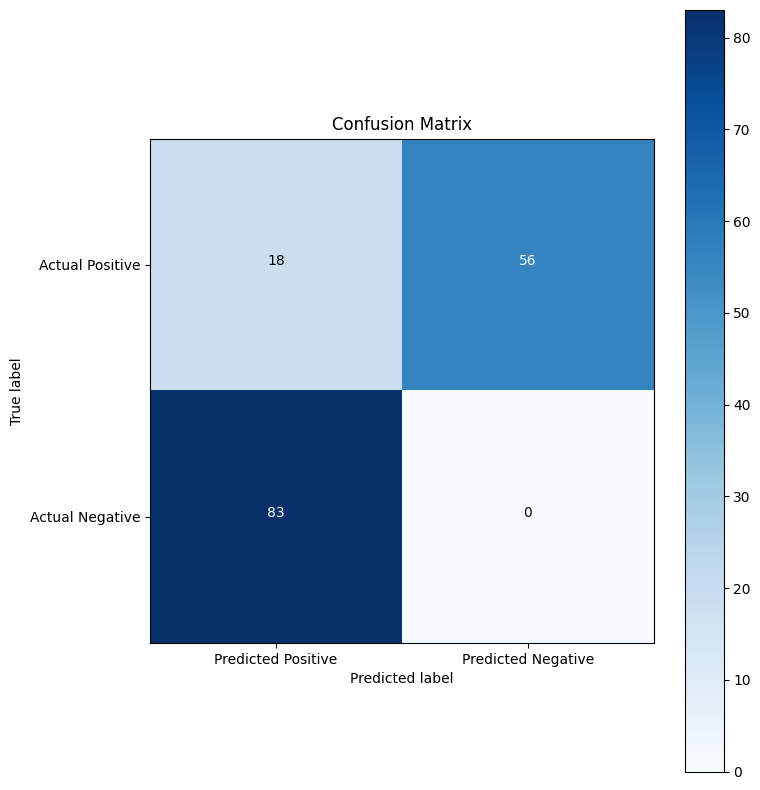

In [209]:
true_positive = len(matches)
false_negative = len(unmatched_gts)
false_positive = len(unmatched_preds)
true_negative = 0  # Not applicable in object detection context

cm = np.array([[true_positive, false_negative], [false_positive, true_negative]])

plt.figure(figsize = (8, 8))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Predicted Positive', 'Predicted Negative'])
plt.yticks([0, 1], ['Actual Positive', 'Actual Negative'])

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
#plt.savefig('CLIP_confusion_matrix.png', dpi = 600)
plt.show()

In [210]:
plt.style.use('fivethirtyeight')

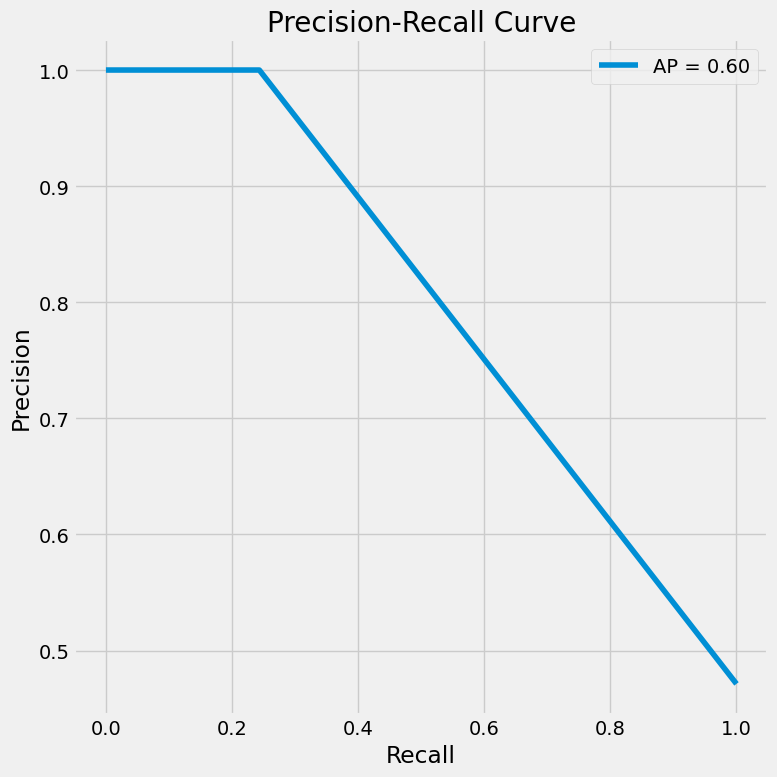

In [211]:
plt.figure(figsize = (8, 8))
plt.plot(recall, precision, label = f'AP = {ap:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.tight_layout()
#plt.savefig('CLIP_PR_curve.png', dpi = 600)
plt.show()

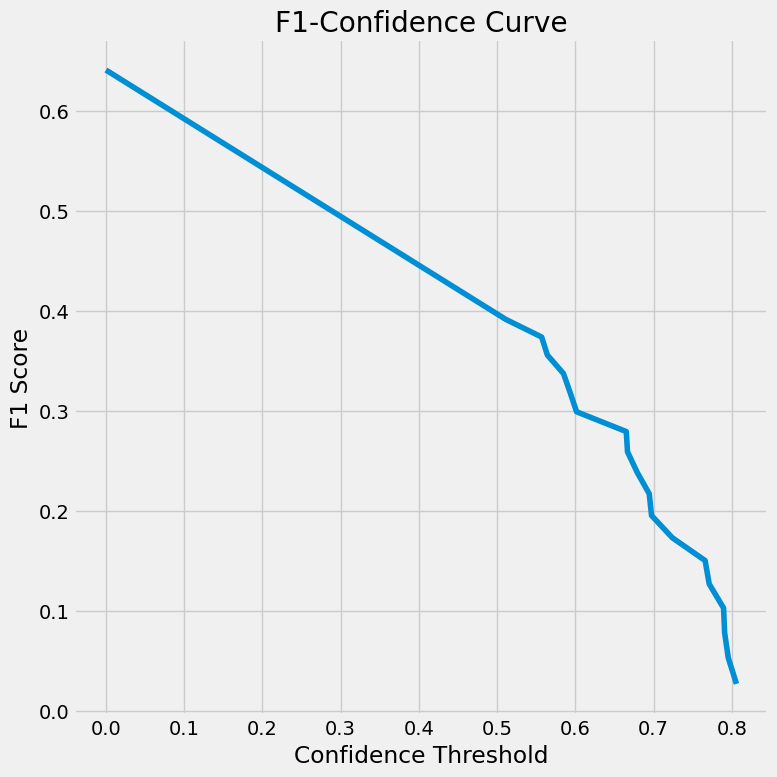

In [212]:
f1_scores = 2 * (precision * recall) / (precision + recall)

plt.figure(figsize = (8, 8))
plt.plot(thresholds, f1_scores[:-1])
plt.xlabel('Confidence Threshold')
plt.ylabel('F1 Score')
plt.title('F1-Confidence Curve')
plt.tight_layout()
#plt.savefig('CLIP_F1_curve.png', dpi = 600)
plt.show()

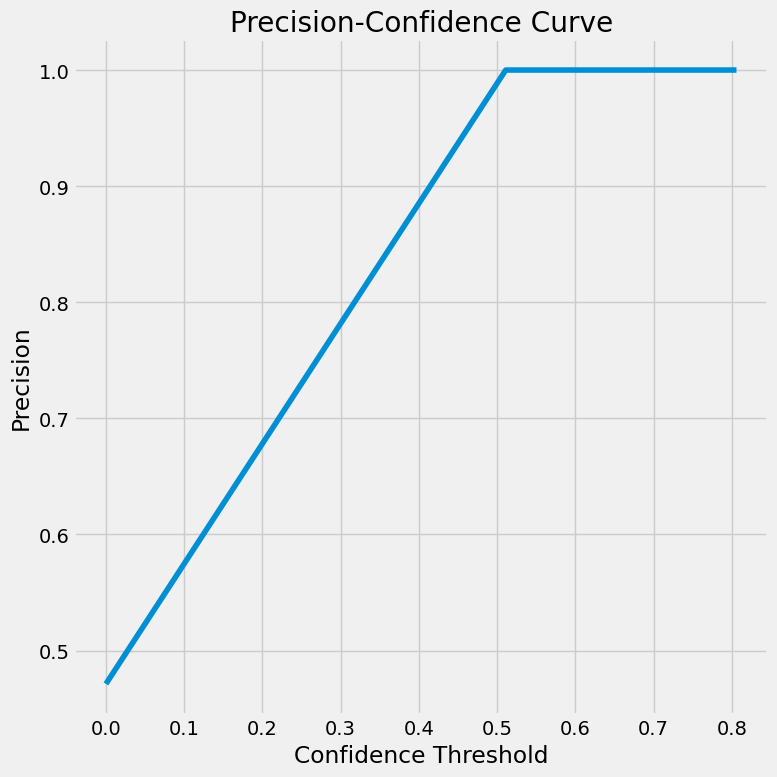

In [213]:
plt.figure(figsize = (8, 8))
plt.plot(thresholds, precision[:-1])
plt.xlabel('Confidence Threshold')
plt.ylabel('Precision')
plt.title('Precision-Confidence Curve')
plt.tight_layout()
#plt.savefig('CLIP_P_curve.png', dpi = 600)
plt.show()

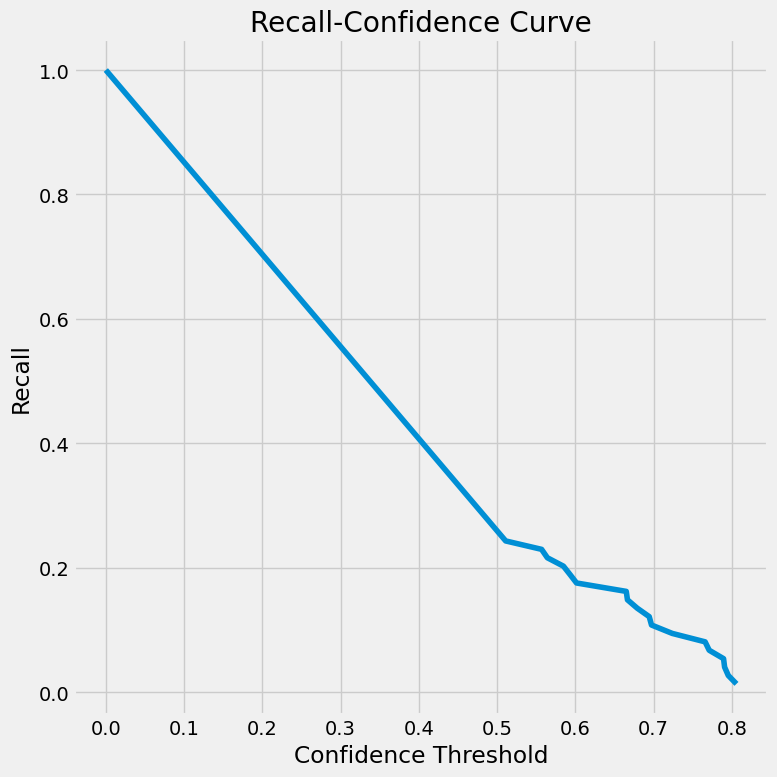

In [214]:
plt.figure(figsize = (8, 8))
plt.plot(thresholds, recall[:-1])
plt.xlabel('Confidence Threshold')
plt.ylabel('Recall')
plt.title('Recall-Confidence Curve')
plt.tight_layout()
#plt.savefig('CLIP_R_curve.png', dpi = 600)
plt.show()

The code below selects a subset of prediction data (pred_df_one_pred_only) containing only images with one predicted bounding box. Then, it randomly selects N images from this subset and displays them along with their ground truth and predicted bounding boxes. The images are shown in a grid layout using subplots, with each subplot representing an image.

In [118]:
plt.style.use('default')

In [119]:
pred_df_one_pred_only = pred_df.drop_duplicates(subset = 'image_name', keep = False).reset_index(drop = True)

In [120]:
random.seed(77)
N = 4
sample_images = random.sample(list(pred_df_one_pred_only['image_name'].unique()), N)

In [121]:
fig, axes = plt.subplots(N, 1, figsize = (35, 35))
for ax, image_name in zip(axes, sample_images):
    image_path = f'/content/Wildfire Smoke.v1-raw.yolov8/test/images/{image_name}.jpg'
    image = Image.open(image_path)

    gt_boxes = gt_df[gt_df['image_name'] == image_name].values
    pred_boxes = pred_df[pred_df['image_name'] == image_name].values

    draw_boxes(image, gt_boxes, pred_boxes)

    ax.imshow(image)
    ax.axis('off')

plt.tight_layout()
#plt.savefig('CLIP_test_samples.png', dpi = 600)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In this research, we applied the CLIP model for zero-shot detection of wildfire smoke in images. Despite achieving poor metrics quantitatively, visual inspection revealed that CLIP's performance was more promising than the numbers suggested.

However, this is a relatively simple dataset as it contains only objects of a single class. A critical limitation of CLIP is its struggle with detecting multiple objects of different classes within the same image.

CLIP's inherent approach to identifying all potential classes can lead to a large number of false positives. This makes it difficult to prioritize and accurately detect the most relevant objects due to the lack of flexibility in score adjustments.

Below is a demonstration of this flaw using an image from the Aquarium dataset. Each image might contain up to seven distinct classes of different objects. To locate them, we have to provide all the classes as prompts. The image we use for demonstration contains two sharks. Ideally, we would expect CLIP to assign high scores to the sharks while suppressing the rest of the classes. However, as you can see in the image below, CLIP has made predictions for all the classes provided as prompts. There is no effective universal way to help the model filter out the relevant classes, despite adjusting the N_CLIP and THRESHOLD parameters.

In [158]:
PROMPTS = ['fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']
PATCH_SIZE = 32
WINDOW = 6
STRIDE = 1
N_CLIP = 4
THRESHOLD = 0.5

In [159]:
IMAGE_PATH = '/content/gdrive/MyDrive/ML/projects/object-detection/wildfire-smoke/CLIP_hard_case.jpg'

In [160]:
im = Image.open(IMAGE_PATH)

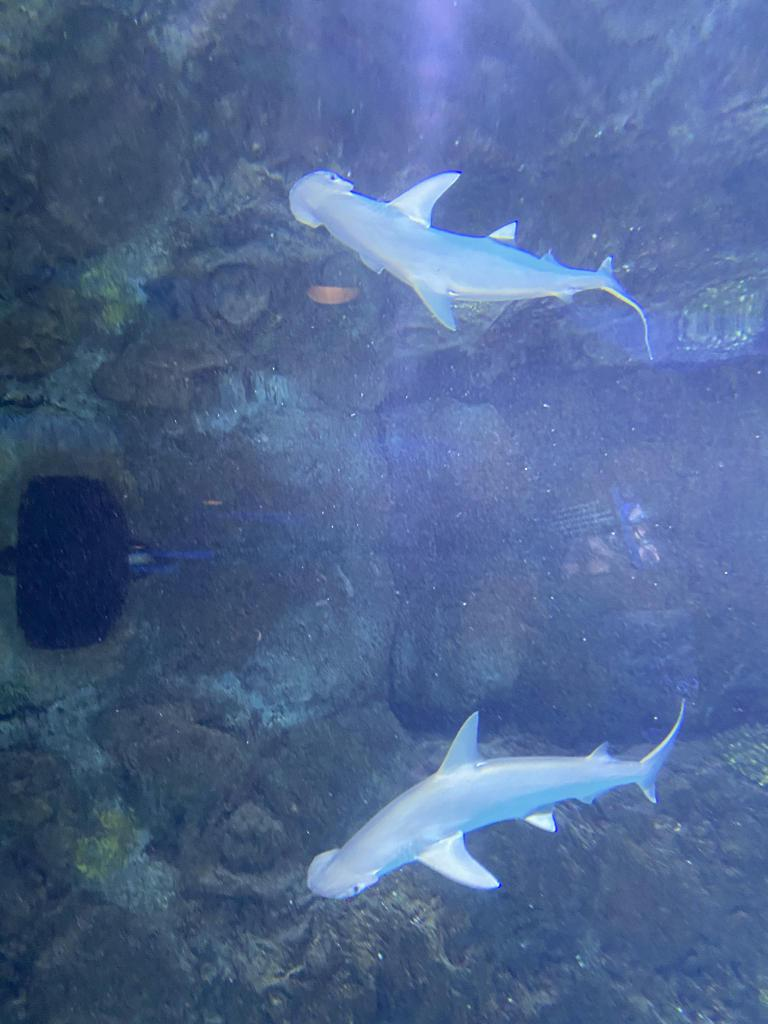

In [161]:
im

In [162]:
trans_t = transforms.ToTensor()
IMG = trans_t(im)

hard_object_detection_results = detect(PROMPTS, IMG, PATCH_SIZE, WINDOW, STRIDE, N_CLIP, THRESHOLD)

  0%|          | 0/7 [00:00<?, ?it/s]

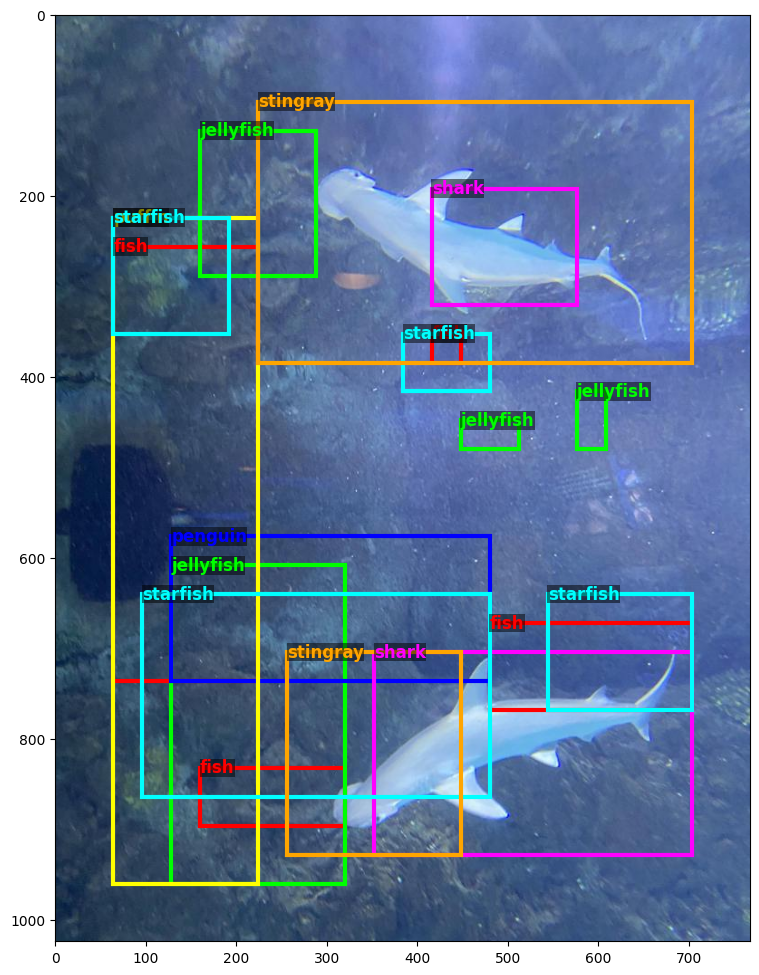

In [165]:
im = Image.open(IMAGE_PATH)
im_np = np.array(im)
fig, ax = plt.subplots(figsize = (im_np.shape[1] * 0.01, im_np.shape[0] * 0.01))
ax.imshow(im_np)

color_map = {
    "fish": "#FF0000",  # Red
    "jellyfish": "#00FF00",  # Green
    "penguin": "#0000FF",  # Blue
    "puffin": "#FFFF00",  # Yellow
    "shark": "#FF00FF",  # Magenta
    "starfish": "#00FFFF",  # Cyan
    "stingray": "#FFA500",  # Orange
}

for res in hard_object_detection_results:

    lbl = PROMPTS[res[0]]
    box = res[1]

    x_min, y_min, width, height = box[0], box[1], box[2], box[3]

    color = color_map.get(lbl)

    rect = patches.Rectangle(
        (x_min, y_min), width, height,
        linewidth = 3, edgecolor = color, facecolor = 'none'
        )

    # Add the patch to the Axes
    ax.add_patch(rect)

    # Add label text near the bounding box
    ax.text(
        x_min, y_min - 10, lbl,
        verticalalignment = 'top', horizontalalignment = 'left',
        color = color, fontsize = 12, weight = 'bold',
        bbox = dict(facecolor = 'black', alpha = 0.5, pad = 0.2, edgecolor = 'none')
        )

plt.tight_layout()
#plt.savefig('CLIP_failed_sample.png', dpi = 600)
plt.show()

While CLIP shows potential for zero-shot object detection, its current limitations underscore the need for further refinement. Specifically, enhancing the model's ability to suppress non-existent classes and focus on the most pertinent ones would significantly improve its practical applicability.